# Percentage based thresholding

In [1]:
# Denoising
import zarr
import zarr.storage
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import stft
from scipy.signal import find_peaks
from collections import defaultdict
from scipy.ndimage import median_filter, gaussian_filter
from skimage import measure
import pandas as pd

In [2]:
# List of shot IDs
shot_ids = [23447, 30005, 30021, 30421]  # Add more as needed

# S3 endpoint
endpoint = "https://s3.echo.stfc.ac.uk"
fs = fsspec.filesystem(
    protocol='simplecache',
    target_protocol="s3",
    target_options=dict(anon=True, endpoint_url=endpoint)
)

In [3]:
store_list = []
zgroup_list = []

# Loop through each shot ID
for shot_id in shot_ids:
    url = f"s3://mast/level2/shots/{shot_id}.zarr"
    
    store = zarr.storage.FSStore(fs=fs, url=url)
    store_list.append(store)
    # open or download the Zarr group
    try:
        zgroup_list.append(zarr.open(store, mode='r'))
        print(f"Loaded shot ID {shot_id}")
        # Do something with zgroup here, like listing arrays:
        # print(list(zgroup.array_keys()))
    except Exception as e:
        print(f"Failed to load shot ID {shot_id}: {e}")

Loaded shot ID 23447
Loaded shot ID 30005
Loaded shot ID 30021
Loaded shot ID 30421


In [4]:
mirnov = [xr.open_zarr(store, group="magnetics") for store in store_list]
ds_list = [m['b_field_pol_probe_omv_voltage'].isel(b_field_pol_probe_omv_channel=1) for m in mirnov]

## STFT or short time fourier transform

In [5]:
def plot_stft_spectrogram(    ds,    shot_id=None,    nperseg=2000,    nfft=2000,    tmin=0.1,    tmax=0.46,    fmax_kHz=50,    cmap='jet'):
    """
    Plot STFT spectrogram for a given xarray DataArray `ds`.
    
    Parameters:
    - ds: xarray.DataArray with a 'time_mirnov' coordinate.
    - shot_id: Optional shot ID for labeling.
    - nperseg: Number of points per STFT segment.
    - nfft: Number of FFT points.
    - tmin, tmax: Time range to display (seconds).
    - fmax_kHz: Max frequency to display (kHz).
    - cmap: Colormap name.
    """
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)

    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, np.abs(Zxx),
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"STFT Spectrogram"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

[None, None, None, None]

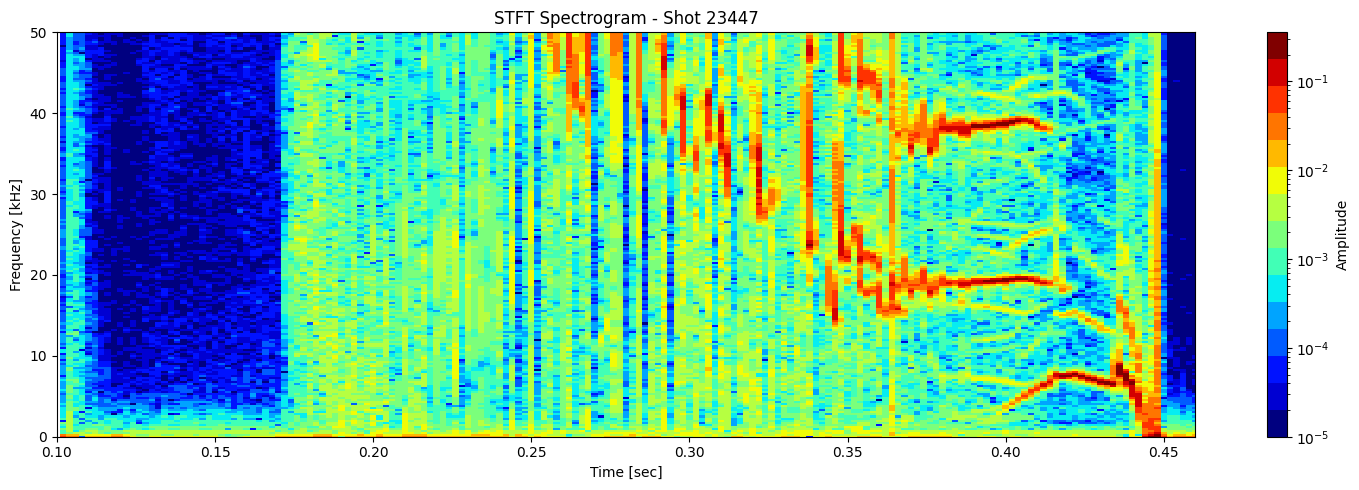

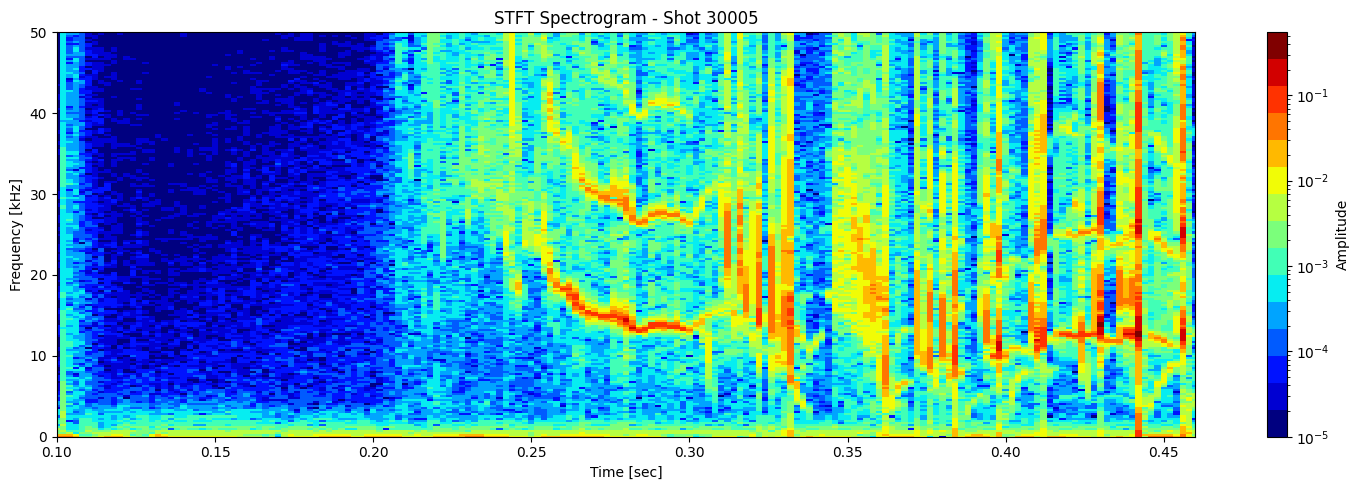

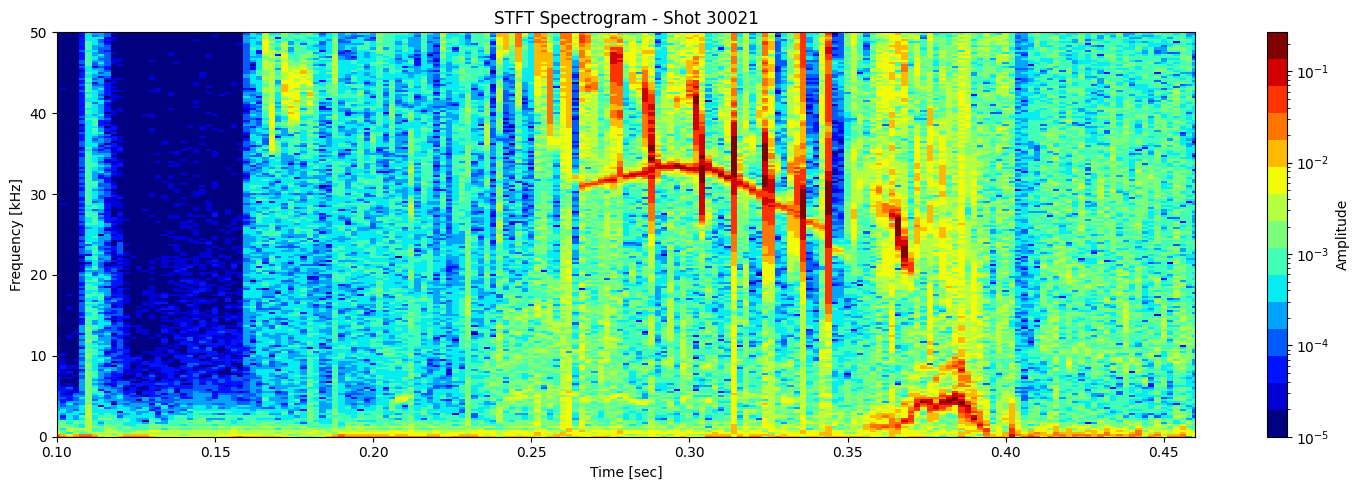

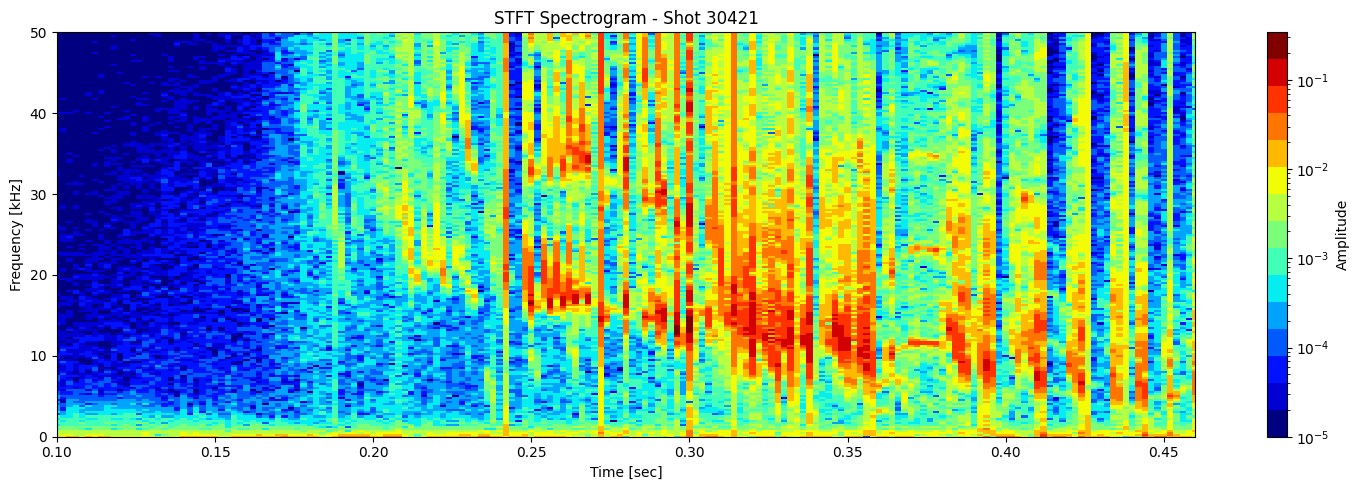

In [6]:
[plot_stft_spectrogram(ds_list[i], shot_ids[i]) for i in range(len(ds_list))]

## Thresholding based on percentage

In [7]:
def plot_amplitude_masking(ds, shot_id=None, nperseg=2000, nfft=2000,
                           sigma=1.0, apply_gaussian=True, apply_mask=True,
                           mask_percentile=60, use_percentage=True,
                           tmin=0.1, tmax=0.46, fmax_kHz=50, cmap='jet'):
    """
    Plots the STFT spectrogram with optional Gaussian blur and masking. This is one function doing everything. No helper needed.

    Parameters:
    - ds: xarray.DataArray with 'time_mirnov'
    - shot_id: Optional shot ID
    - apply_gaussian: Whether to apply Gaussian blur
    - apply_mask: Whether to apply masking
    - mask_percentile: If use_percentage=True, keep top X% of points.
                       Else, mask values below the Xth percentile.
    - use_percentage: Use percentage thresholding instead of percentile
    """

    # Compute STFT
    sample_rate = 1 / float(ds.time_mirnov[1] - ds.time_mirnov[0])
    f, t, Zxx = stft(ds.values, fs=int(sample_rate), nperseg=nperseg, nfft=nfft)
    magnitude = np.abs(Zxx)  # Take magnitude of complex STFT

    # Optional Gaussian blur (for smoothing the spectrogram)
    if apply_gaussian:
        magnitude = gaussian_filter(magnitude, sigma=sigma)

    # Clip negative values just in case blur introduced due to skewed data like sharp gradients
    magnitude = np.clip(magnitude, 0, None)

    # Apply masking
    if apply_mask:
        if use_percentage:
            # Flatten and sort finite values to find cutoff for top X% values
            valid = magnitude[np.isfinite(magnitude)].flatten()
            if valid.size > 0:
                sorted_vals = np.sort(valid)
                cut_index = int((1 - mask_percentile / 100) * len(sorted_vals))
                cutoff_value = sorted_vals[cut_index]
                # Mask all values below cutoff
                magnitude = np.where(magnitude >= cutoff_value, magnitude, np.nan)
        else:
            # Use standard percentile-based thresholding
            threshold = np.percentile(magnitude, mask_percentile)
            magnitude = np.where(magnitude >= threshold, magnitude, np.nan)

    # save a copy of the segmented spectrogram
    segmented_stft = magnitude.copy()


    # Skip if everything got masked (to avoid plotting empty images)
    if not np.any(np.isfinite(magnitude)):
        print(f"Shot {shot_id} — all values masked. Skipping plot.")
        return

    # Plot the spectrogram
    fig, ax = plt.subplots(figsize=(15, 5))
    cax = ax.pcolormesh(
        t, f / 1000, magnitude,
        shading='nearest',
        cmap=plt.get_cmap(cmap, 15),
        norm=LogNorm(vmin=1e-5)
    )
    ax.set_ylim(0, fmax_kHz)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [sec]')
    title = f"Filtered STFT - Shot {shot_id}" if shot_id else "Filtered STFT"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label='Amplitude')
    plt.tight_layout()

    return t, f, segmented_stft, Zxx


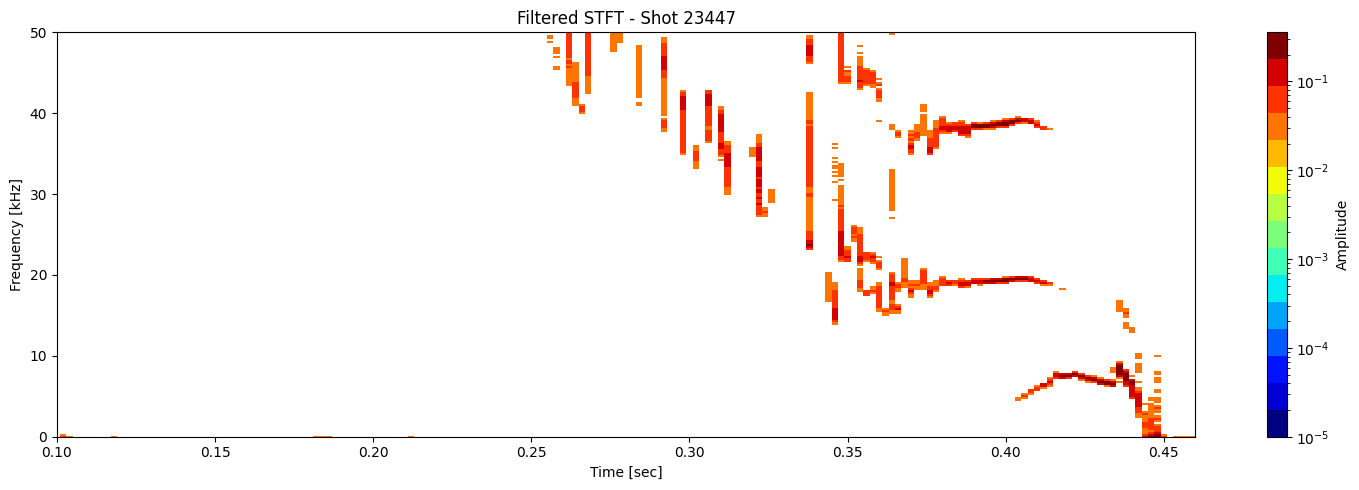

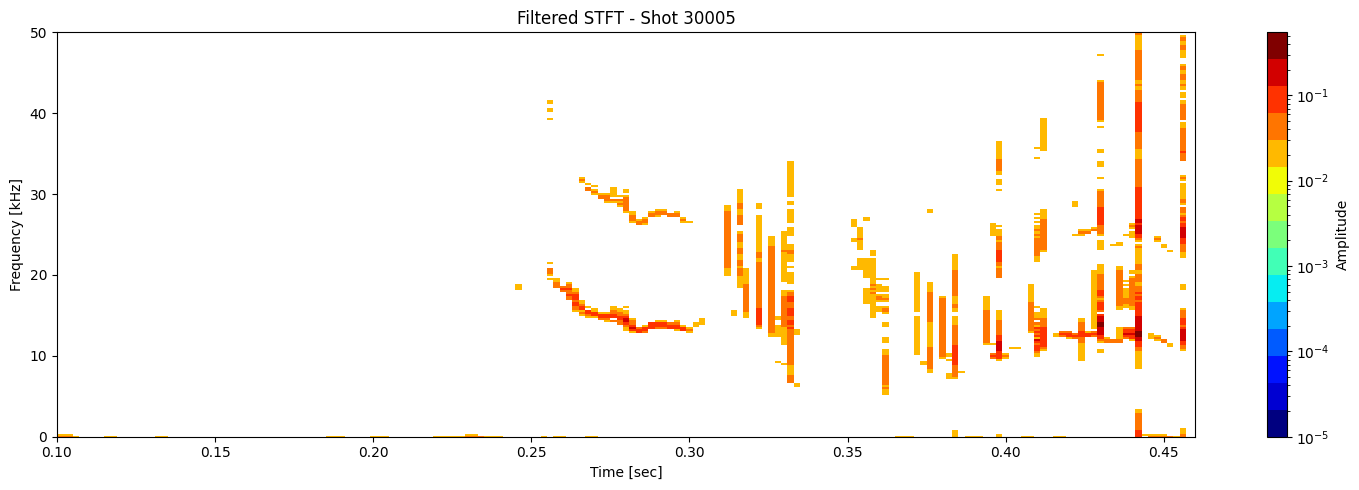

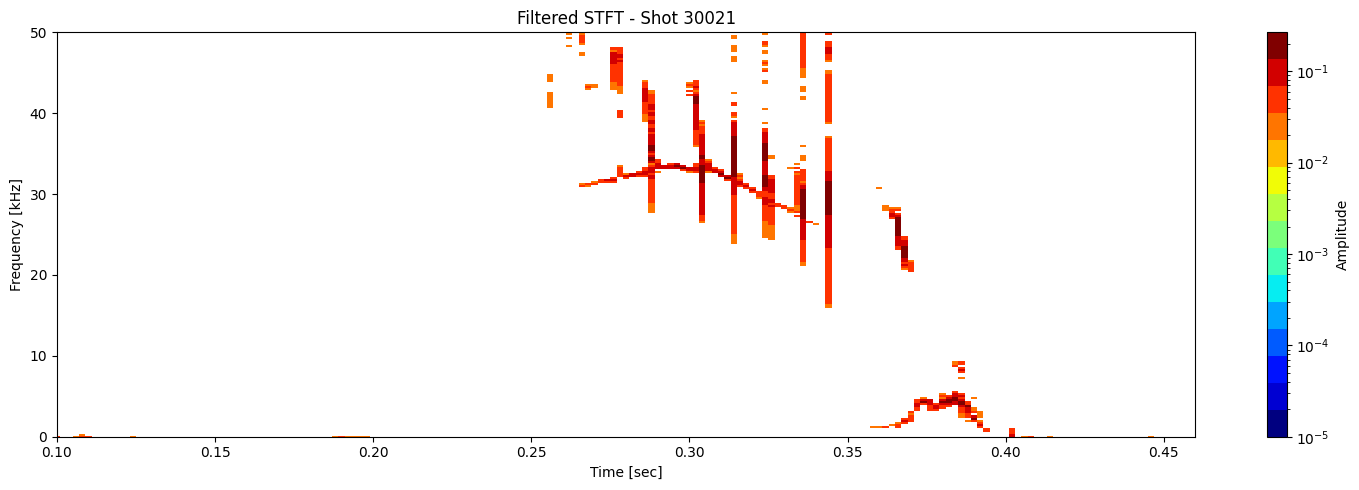

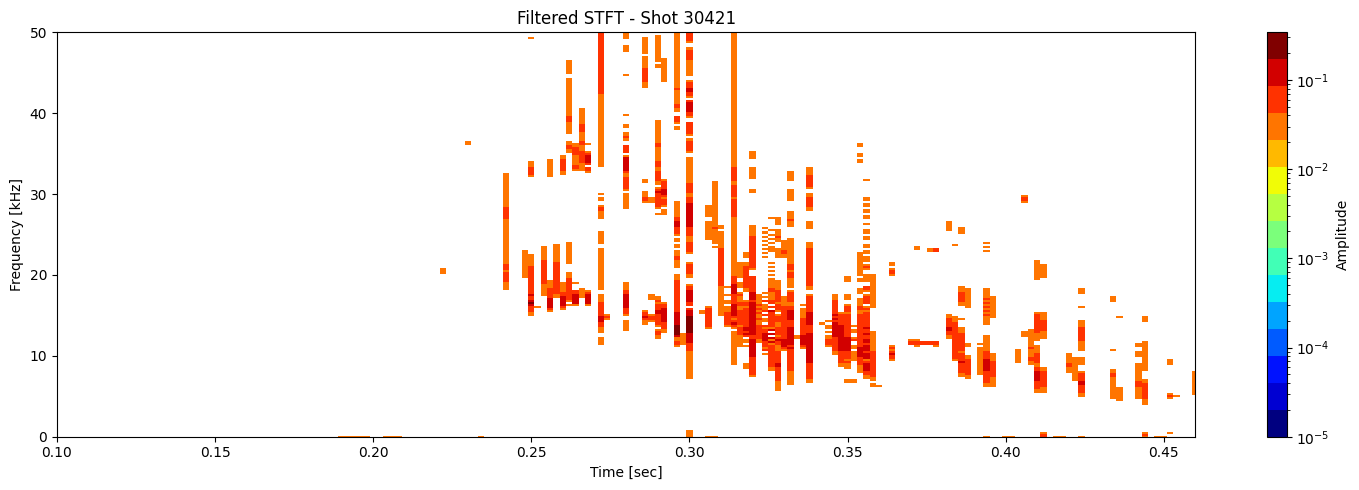

In [8]:
results = [plot_amplitude_masking(ds_list[i], shot_ids[i], mask_percentile=1, sigma=0.1) for i in range(len(ds_list))]
t_list, f_list, seg_list, Zxx_list = zip(*results)

## Contour detection

In [9]:
def plot_spectrogram_with_contours(Zxx, f, t, contours, shot_id=None, vmin=1e-5):

    f_kHz = f / 1000

    fig, ax = plt.subplots(figsize=(12, 5))
    cax = ax.pcolormesh(t, f_kHz, np.abs(Zxx), shading='nearest',
                        norm=LogNorm(vmin=vmin), cmap='jet')

    for contour in contours:
        ax.plot(t[np.clip(contour[:, 1].astype(int), 0, len(t) - 1)],
                f_kHz[np.clip(contour[:, 0].astype(int), 0, len(f) - 1)],
                color='black', lw=0.5)


    ax.set_ylim(0, 50)
    ax.set_xlim(0.1, 0.46)
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Frequency [kHz]')
    title = "STFT with Contour Overlay"
    if shot_id is not None:
        title += f" - Shot {shot_id}"
    ax.set_title(title)
    plt.colorbar(cax, ax=ax, label="Amplitude")
    plt.grid(True)
    plt.tight_layout()

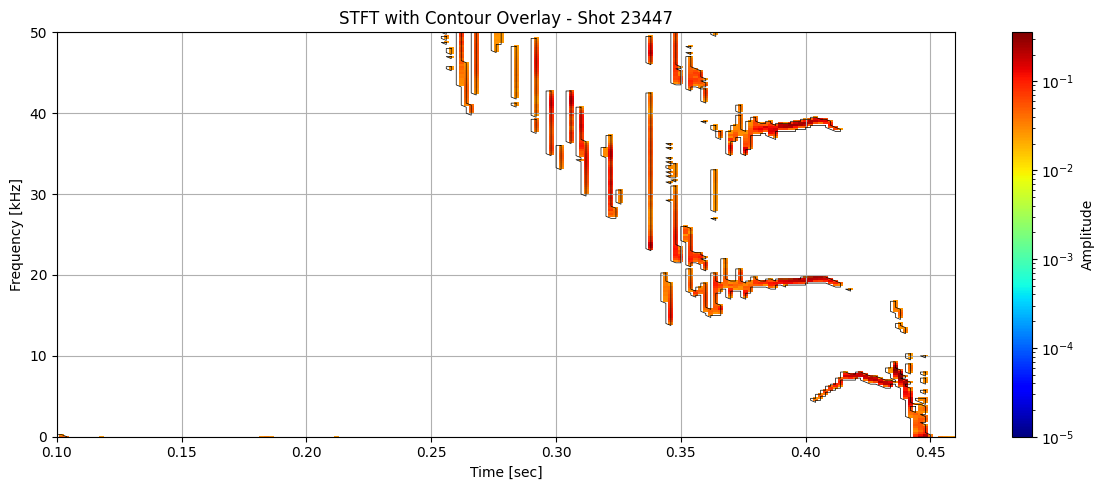

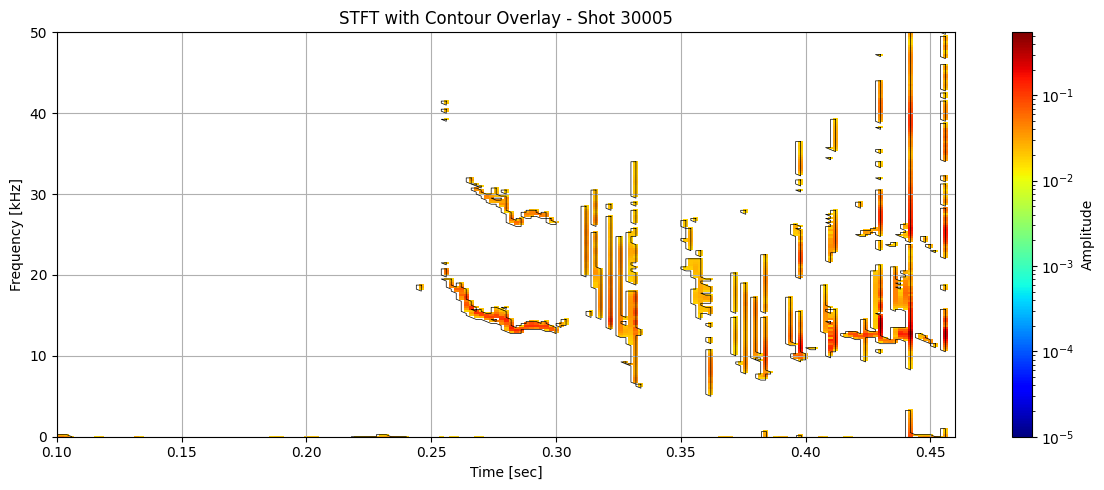

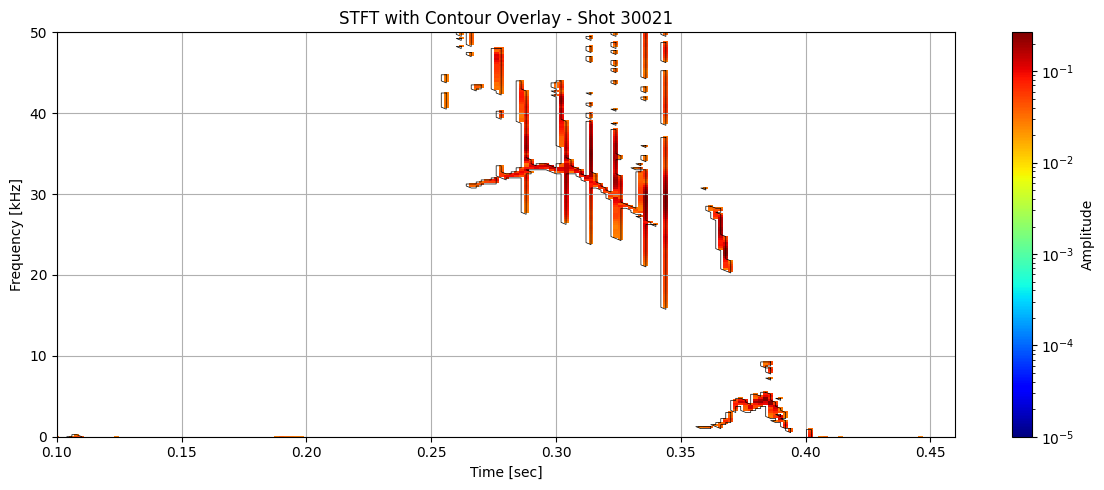

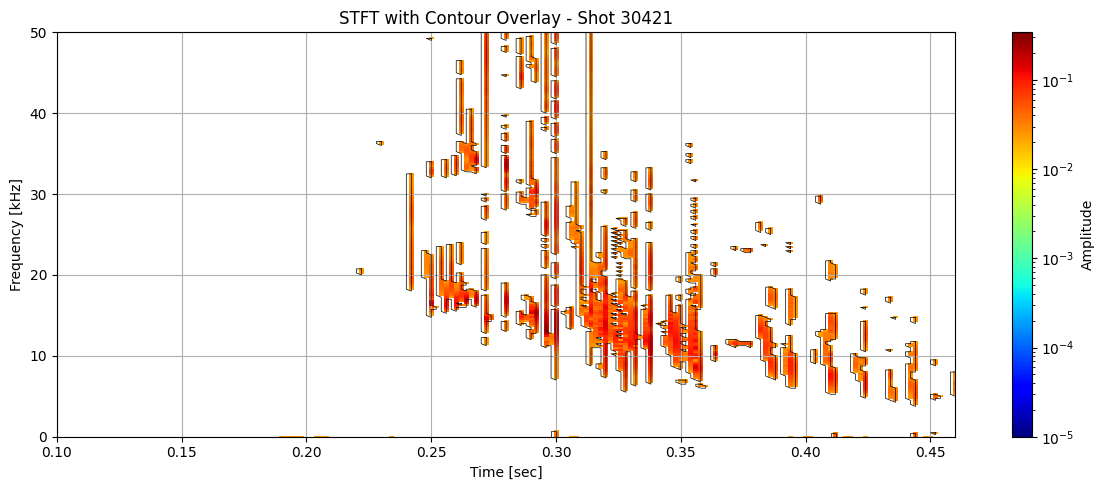

In [10]:
for i in range(len(ds_list)):
    # Use masked STFT (seg_list[i]) to extract binary mask
    binary_mask = np.isfinite(seg_list[i]).astype(float)
    # Get contours at 0.5 (standard threshold for binary masks)
    contours = measure.find_contours(binary_mask, level=0.5)
    plot_spectrogram_with_contours(seg_list[i], f_list[i], t_list[i], contours, shot_id=shot_ids[i])


## Extract information about each contour

In [31]:
def extract_contour_features(contour, t, f, Zxx):
    """Extract features from a single contour."""
    time_idx = np.clip(contour[:, 1].astype(int), 0, len(t) - 1)
    freq_idx = np.clip(contour[:, 0].astype(int), 0, len(f) - 1)
    
    times = t[time_idx]
    freqs = f[freq_idx]# / 1000  # in kHz
    amps = np.abs(Zxx[freq_idx, time_idx])
    
    # Handle degenerate contours
    if len(times) < 2:
        return None
    
    # Features
    duration = times.max() - times.min()
    freq_span = freqs.max() - freqs.min()
    slope = np.polyfit(times, freqs, 1)[0]
    avg_amp = np.mean(amps)
    max_amp = np.max(amps)
    
    return {
        'duration': duration,
        'freq_span': freq_span,
        'slope': slope,
        'avg_amp': avg_amp,
        'max_amp': max_amp,
        'start_time': times.min(),
        'end_time': times.max(),
        'start_freq': freqs[0],
        'end_freq': freqs[-1],
        'length': len(times),
    }


In [32]:
# Initialize a list to collect all feature DataFrames
all_feature_dfs = []
# Extract features from all contours
# Loop through each shot to extract contour features
for i in range(len(ds_list)):
    #  Binary mask from segmented STFT (NaNs were introduced during masking)
    binary_mask = np.isfinite(seg_list[i]).astype(float)

    #  Detect contours at 0.5 level (standard threshold for binary masks)
    contours = measure.find_contours(binary_mask, level=0.5)

    #  Extract features for each contour using helper
    features = [extract_contour_features(c, t_list[i], f_list[i], Zxx_list[i]) for c in contours]

    #  Filter out any invalid results (None entries)
    features = [f for f in features if f is not None]

    for f in features:
        f['shot_id'] = shot_ids[i]  # Add shot ID to each feature dict

    all_feature_dfs.extend(features)

# Concatenate into a single DataFrame
df_all = pd.DataFrame(all_feature_dfs)

In [33]:
df_all.head()

,duration,freq_span,slope,avg_amp,max_amp,start_time,end_time,start_freq,end_freq,length,shot_id
0,0.004,249.9995,-31249.875000,NaN,NaN,0.100000,0.104000,0.0,0.0,6,23447
1,0.002,0.0000,0.000000,0.023275,0.024961,0.116000,0.118000,0.0,0.0,3,23447
2,0.006,0.0000,0.000000,0.027723,0.033559,0.180000,0.186000,0.0,0.0,5,23447
3,0.002,0.0000,0.000000,0.024394,0.025508,0.210000,0.212000,0.0,0.0,3,23447
4,0.048,9249.9815,-69827.673147,0.042272,0.294688,0.402001,0.450001,0.0,0.0,172,23447


In [34]:
df_clean = df_all.dropna()

###### More filtering needed. A lot of garbage contour still left #######
df_clean = df_clean[(df_clean['duration'] > 0.004) & 
                    (df_clean['avg_amp'] > 1e-4) &
                    (df_clean['length'] >= 5)&
                    (df_clean['freq_span'] > 0.1) ]

# select all rows with shot_id 23447
df_clean[df_clean['shot_id'] == 23447].head()

,duration,freq_span,slope,avg_amp,max_amp,start_time,end_time,start_freq,end_freq,length,shot_id
4,0.048,9249.9815,-69827.673147,0.042272,0.294688,0.402001,0.450001,0.0000,0.0000,172,23447
7,0.004,749.9985,-19097.145833,0.024279,0.035895,0.444001,0.448001,4749.9905,4749.9905,11,23447
14,0.004,1249.9975,-145473.556035,0.020093,0.035396,0.436001,0.440001,13999.9720,13999.9720,15,23447
15,0.004,6499.9870,-485785.402238,0.031570,0.111901,0.342001,0.346001,20249.9595,20249.9595,57,23447
16,0.004,2249.9955,-231962.159397,0.019929,0.046078,0.434001,0.438001,16749.9665,16749.9665,23,23447


In [40]:
df_clean.describe()

,duration,freq_span,slope,avg_amp,max_amp,start_time,end_time,start_freq,end_freq,length,shot_id,cluster
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000
mean,0.007450,4502.490995,-8.969984e+04,0.025796,0.068642,0.351251,0.358701,47598.654803,47598.654803,54.08500,29324.920000,0.265000
std,0.008922,6256.641733,2.544083e+05,0.006230,0.052303,0.097829,0.098188,36241.699217,36241.699217,87.49494,2182.622311,0.544294
min,0.004000,249.999500,-1.115897e+06,0.013975,0.019890,0.054000,0.058000,0.000000,0.000000,6.00000,23447.000000,0.000000
25%,0.004000,937.498125,-1.479111e+05,0.021910,0.037924,0.294001,0.300001,16374.967250,16374.967250,13.00000,30005.000000,0.000000
50%,0.004000,2249.995500,-3.846138e+04,0.024957,0.049173,0.332001,0.336001,39124.921750,39124.921750,27.00000,30021.000000,0.000000
75%,0.006000,6499.987000,3.289461e+04,0.028524,0.076892,0.392501,0.404001,83749.832500,83749.832500,65.50000,30021.000000,0.000000
max,0.062000,48999.902000,1.068889e+06,0.055376,0.374299,0.662001,0.666001,138499.723000,138499.723000,781.00000,30421.000000,2.000000


## Simple clustering

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [36]:
features = df_clean[['duration', 'freq_span', 'slope', 'avg_amp', 'max_amp']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled)


In [37]:
def plot_clustered_contours_by_shot(df, t_range=(0.1, 0.46), f_range=(0, 50), cluster_names=None):
    """
    Plots clustered mode segments (time vs frequency) separately for each shot_id.

    Parameters:
    - df: DataFrame with extracted features and a 'cluster' column.
    - t_range: Tuple (tmin, tmax) for x-axis.
    - f_range: Tuple (fmin, fmax) for y-axis.
    - cluster_names: Optional dict mapping cluster numbers to names.
    """
    cluster_colors = ['red', 'green', 'blue', 'purple', 'orange']
    shots = df['shot_id'].unique()

    for shot in shots:
        plt.figure(figsize=(12, 6))
        shot_data = df[df['shot_id'] == shot]

        for cluster_id in sorted(shot_data['cluster'].dropna().unique()):
            cluster_df = shot_data[shot_data['cluster'] == cluster_id]

            for _, row in cluster_df.iterrows():
                plt.hlines(
                    y=row['start_freq'] / 1000,
                    xmin=row['start_time'],
                    xmax=row['end_time'],
                    colors=cluster_colors[int(cluster_id)],
                    linewidth=2,
                    label=f'Cluster {cluster_id}' if f'Cluster {cluster_id}' not in plt.gca().get_legend_handles_labels()[1] else ""
                )

        plt.title(f"Clustered Mode Segments – Shot {shot}")
        plt.xlabel("Time [sec]")
        plt.ylabel("Frequency [kHz]")
        plt.xlim(*t_range)
        plt.ylim(*f_range)
        handles, labels = plt.gca().get_legend_handles_labels()
        if cluster_names:
            labels = [cluster_names.get(int(label.split()[-1]), label) for label in labels]
        plt.legend(handles, labels)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


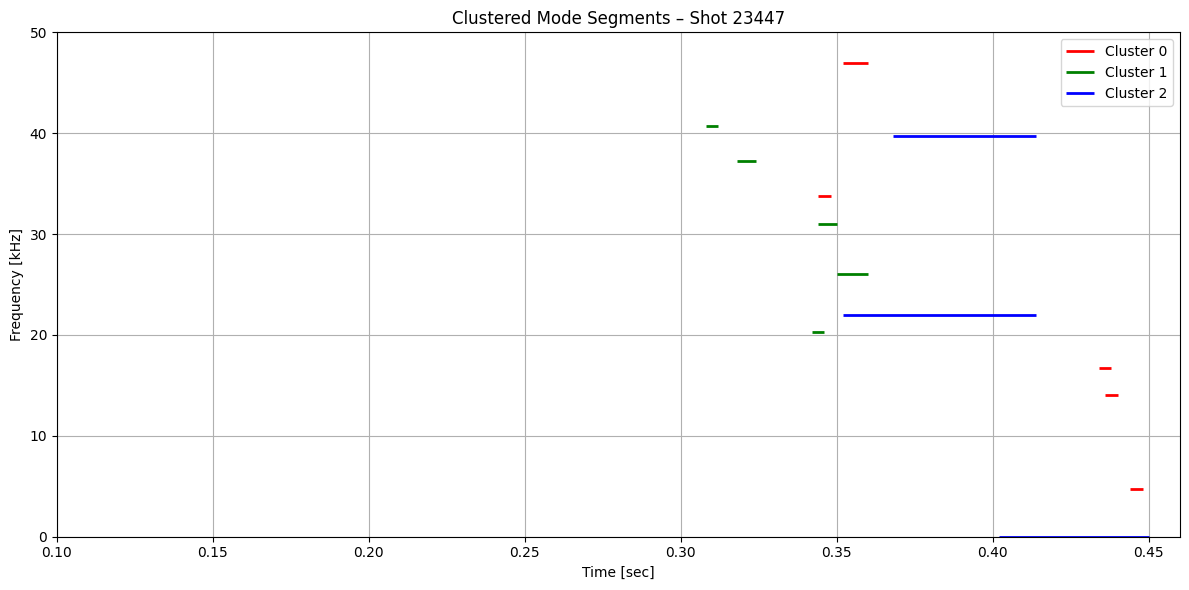

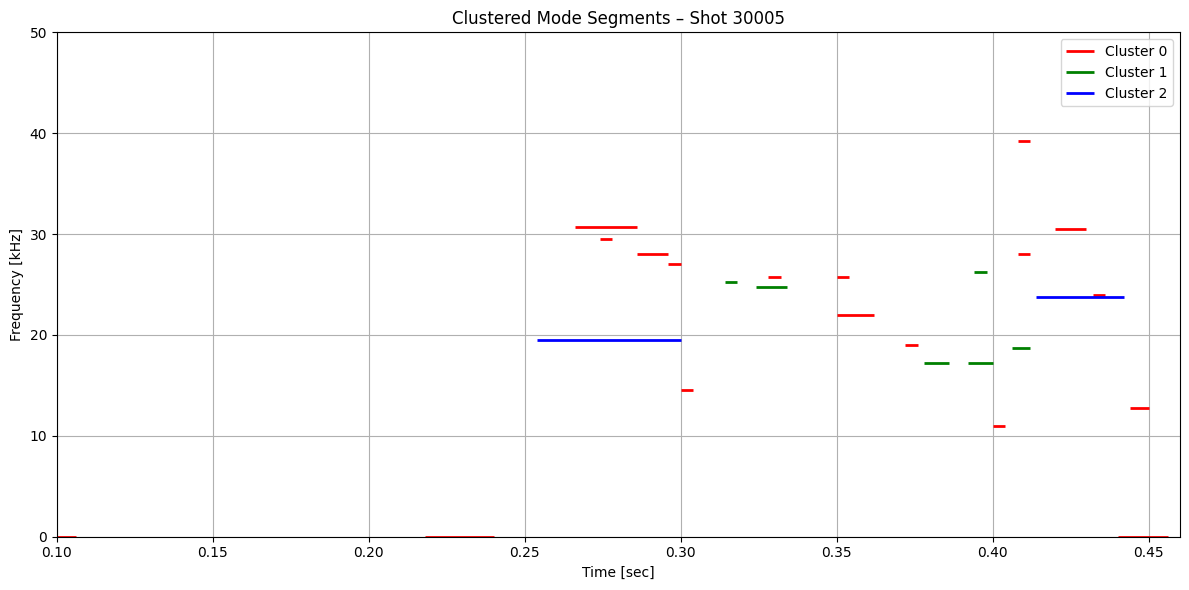

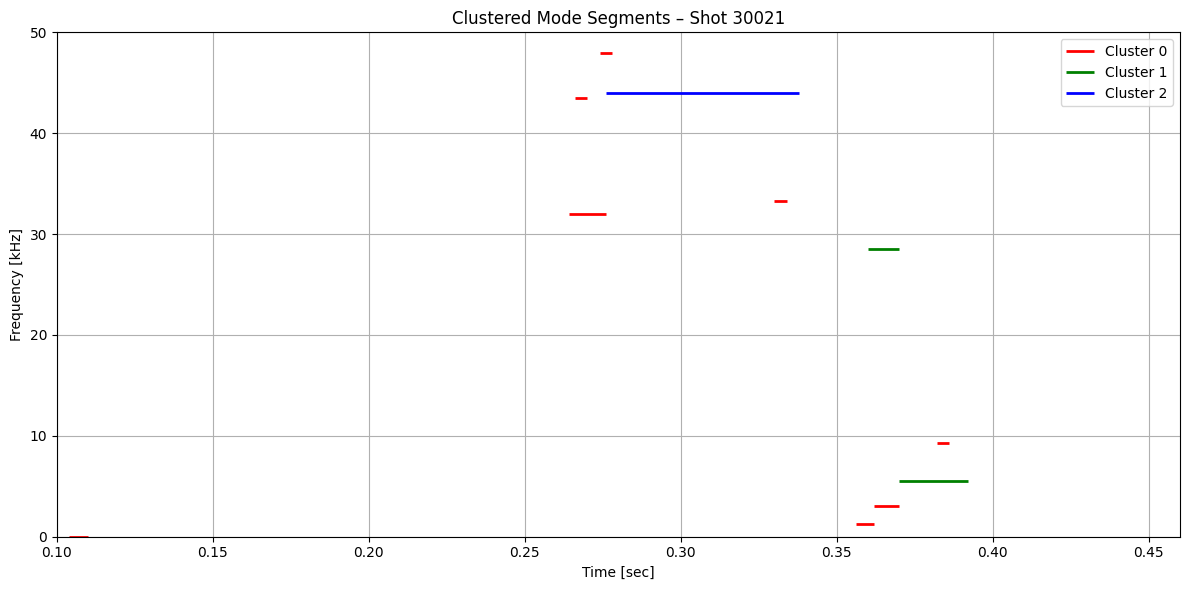

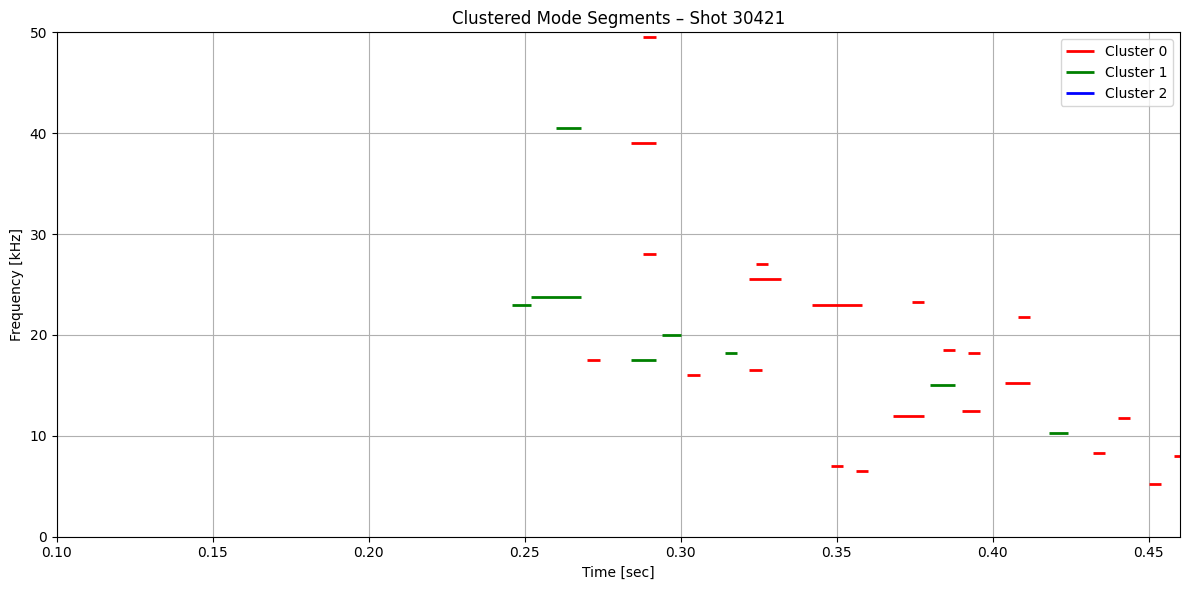

In [38]:
plot_clustered_contours_by_shot(df_clean)
